In [1]:
!date

Thu May  1 04:22:34 PM EDT 2025


In [2]:
pwd

'/projects/sccn/andromeda1/aglinska/BC-ABCD-denoise/Code'

In [3]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ants

In [4]:
from sklearn.decomposition import PCA
from sklearn import linear_model

In [5]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [10]:
ls ../Data/BrainIAK/

brainIAK_cf.nii.gz                   brainIAK_observation.nii.gz
brainIAK_gm.nii.gz                   brainIAK_observation-v2.nii.gz
brainIAK_noise.nii.gz                brainIAK_signal.nii.gz
brainIAK_noise-v2.nii.gz             brainIAK_signal-v2.nii.gz
brainIAK_observation_compcor.nii.gz  YZ-Realistic_data_simulation.ipynb


In [11]:
gm = ants.image_read('../Data/BrainIAK/brainIAK_gm.nii.gz')
cf = ants.image_read('../Data/BrainIAK/brainIAK_cf.nii.gz')

In [12]:
noise = ants.image_read('../Data/BrainIAK/brainIAK_noise-v2.nii.gz')
signal = ants.image_read('../Data/BrainIAK/brainIAK_signal-v2.nii.gz')
observation = ants.image_read('../Data/BrainIAK/brainIAK_observation-v2.nii.gz')

In [13]:
noi_list = observation.numpy()[cf.numpy()==1]
obs_list = observation.numpy()[gm.numpy()==1]

In [14]:
conf_pcs = PCA(n_components=5).fit_transform(noi_list.transpose()) # Input is [time x voxels] , output is [time x components]
lin_reg = linear_model.LinearRegression()
lin_reg.fit(conf_pcs,obs_list.transpose());
obs_compcor = obs_list.transpose()-lin_reg.predict(conf_pcs)
obs_compcor = obs_compcor.transpose()
obs_compcor.shape

/home/aglinska/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:640: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var


(44212, 156)

In [15]:
obs_compcor.transpose().shape

(156, 44212)

In [16]:
# conf_pcs = PCA(n_components=5).fit_transform(noi_list_coords[:,0,:].transpose()) # Input is [time x voxels] , output is [time x components]
# lin_reg = linear_model.LinearRegression()
# lin_reg.fit(conf_pcs,ffa_list_coords[:,0,:].transpose()); # X [time x components] Y is [Time x Voxels]
# ffa_compcorr = ffa_list_coords[:,0,:].transpose()-lin_reg.predict(conf_pcs) # time first
# ffa_compcorr = ffa_compcorr.transpose() # Transpose back

In [17]:
new_im = np.zeros(observation.shape)
new_im[gm.numpy()==1]=obs_compcor

In [18]:
observation.new_image_like(new_im).to_filename('../Data/BrainIAK/brainIAK_observation_compcor.nii.gz')

In [19]:
compcor_list = new_im[gm.numpy()==1]
GT_list = signal.numpy()[gm.numpy()==1]

In [20]:
r_raw = correlate_columns(obs_list.transpose(), GT_list.transpose())
r_compcor = correlate_columns(obs_compcor.transpose(), GT_list.transpose())

<ipython-input-5-9f9a06f806b9>:27: RuntimeWarning: invalid value encountered in true_divide
  correlation = numerator / denominator


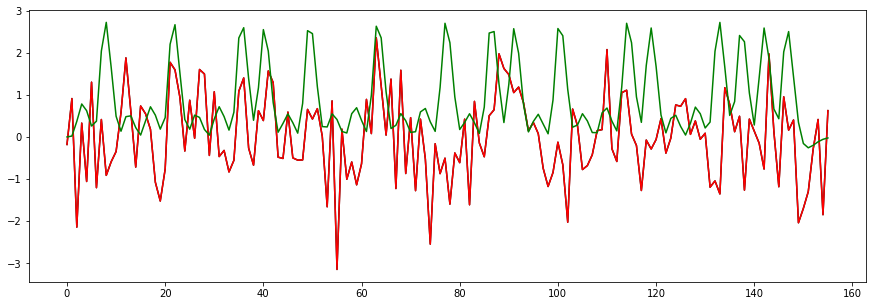

In [21]:
plt.figure(figsize=(15,5))
plt.plot(obs_list[0,:],'k-')
plt.plot(obs_compcor[0,:],'r-')
plt.plot(GT_list[0,:],'g-')

In [29]:
np.nanmean(r_raw)

0.28818873

In [30]:
np.nanmean(r_compcor)

0.28818873

In [36]:
comp = ants.image_read('../Data/BrainIAK/brainIAK_compcor-v2.nii')
compcor_list = comp.numpy()[gm.numpy()==1]
r_compcor = correlate_columns(compcor_list.transpose(), GT_list.transpose())

<ipython-input-5-9f9a06f806b9>:27: RuntimeWarning: invalid value encountered in true_divide
  correlation = numerator / denominator


In [39]:
np.nanmean(r_compcor)

0.33572462